In [ ]:
import os
import re
import sys
import nltk
import json
import pickle
import joblib
import shutil
import seaborn as sns
import numpy as np
import unicodedata
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
from scipy.special import softmax
from pathlib import Path
from functools import lru_cache
import tqdm as notebook_tqdm
from tempfile import mkdtemp
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from typing import List, Tuple
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from collections import Counter, defaultdict
from nltk.tokenize import sent_tokenize
from scipy.sparse import coo_matrix, load_npz
from sklearn.feature_extraction.text import TfidfVectorizer


Import Datasets

The MIND-small training and validation datasets can be downloaded from the following link: https://msnews.github.io/

In [76]:
# train data

# news metadata
news_cols = ["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"]
news_train = pd.read_csv("MINDsmall_train/news.tsv", sep="\t", header=None, names=news_cols)

# user behaviors
user_cols = ["impression_id", "user_id", "time", "clicked_news", "impressions"]
user_train = pd.read_csv("MINDsmall_train/behaviors.tsv", sep="\t", header=None, names=user_cols)

news_train.head()


,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [77]:
user_train.head()


,impression_id,user_id,time,clicked_news,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [78]:
# train data summary

print(len(news_train), len(user_train))
print(user_train['user_id'].nunique())
print(news_train.isna().sum())

51282 156965
50000
news_id                 0
category                0
subcategory             0
title                   0
abstract             2666
url                     0
title_entities          3
abstract_entities       4
dtype: int64


In [ ]:
# validation data

news_val = pd.read_csv("MINDsmall_dev/news.tsv", sep="\t", header=None, names=news_cols)
user_val = pd.read_csv("MINDsmall_dev/behaviors.tsv", sep="\t", header=None, names=user_cols)


In [80]:
# val data summary
print(len(news_val), len(user_val))
print(user_val['user_id'].nunique())
print(news_val.isna().sum())

42416 73152
50000
news_id                 0
category                0
subcategory             0
title                   0
abstract             2021
url                     0
title_entities          2
abstract_entities       2
dtype: int64


In [81]:
# overall counts
total_news = pd.concat([news_train, news_val]).news_id.nunique()
total_impressions = len(user_train) + len(user_val)
total_users = pd.concat([user_train, user_val]).user_id.nunique()
print("unique news articles:", total_news)
print("total impression logs:", total_impressions)
print("unique users:", total_users)


unique news articles: 65238
total impression logs: 230117
unique users: 94057


Data Cleaning

In [82]:
## Clean news dataset

# remove excessive whitespaces, line breaks
def remove_whitespaces(text):
    text = re.sub(r'\r\n', '\n', text)
    text = re.sub(r'[ \t]+', ' ', text) # multiple spaces into single space
    text = re.sub(r'\n{3,}', '\n\n', text) # 3+ consecutive newlines into two to keep paragraph breaks
    return text.strip() # drop leading/trailing whitespaces

def clean_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    # remove HTML tags
    tags = re.compile(r"<[^>]+>|&[a-zA-Z]+;")
    if isinstance(text, str) and tags.search(text):
        text = BeautifulSoup(text, "lxml").get_text(separator=" ")
    # standardize unicode/punctuation for tokenizer consistency
    text = unicodedata.normalize("NFKC", text)
    text = remove_whitespaces(text)
    # remove rule lines ------ / =====
    text = re.sub(r"(?:^|\n)[\-=]{4,}(?:\n|$)", "\n", text)
    return text.strip()

def cleandf(df):
    df_clean = df.copy()
    # add cleaned columns
    df_clean["title_clean"] = df_clean["title"].map(clean_text)
    df_clean["abstract_clean"]  = df_clean["abstract"].map(clean_text)

    # if abstract is short, title only
    abs_min_chars = 30
    use_title_only = df_clean["abstract_clean"].str.len() < abs_min_chars
    df_clean["content"] = np.where(
        use_title_only,
        df_clean["title_clean"].str.strip(),
        (df_clean["title_clean"].str.strip() + "\n\n" + df_clean["abstract_clean"].str.strip()).str.strip()
    )
    df_clean["content_plain"] = (df_clean["title_clean"] + " " + df_clean["abstract_clean"]).str.strip()

    # mark content that is too short for NLP models
    min_chars = 50
    min_tokens = 5
    df_clean["is_short"] = ~(
        (df_clean["content"].str.len() >= min_chars) &
        (df_clean["content"].str.split().map(len) >= min_tokens)
    )

    # combine entities from title and abstract
    def parse_entities(s):
        try:
            if isinstance(s, str):
                arr = json.loads(s)
            elif isinstance(s, list):
                arr = s
            else:
                arr = []
            labels = [x.get("Label") for x in arr if isinstance(x, dict) and x.get("Label")]
            return set(map(str.lower, labels))
        except Exception:
            return set()
    title_sets = df_clean["title_entities"].apply(parse_entities)
    abs_sets = df_clean["abstract_entities"].apply(parse_entities)
    df_clean["entities"] = title_sets.combine(abs_sets, lambda a, b: (a or set()).union(b or set()))
    df_clean["entities"] = df_clean["entities"].apply(lambda s: sorted(s) if isinstance(s, set) else [])

    # merge ultra-rare categories
    merge = {"games":"entertainment","northamerica":"news","middleeast":"news"}
    df_clean["category_merged"] = df_clean["category"].replace(merge)
    df_clean["category"] = df_clean["category"].astype("category")
    df_clean["subcategory"] = df_clean["subcategory"].astype("category")
    df_clean["category_merged"] = df_clean["category_merged"].astype("category")

    # get source domain from URL
    def extract_domain(url):
        try:
            parsed = urlparse(url)
            domain = parsed.netloc.lower()
            domain = re.sub(r"^(www\.|m\.|amp\.)", "", domain)
            return domain.strip()
        except Exception:
            return ""
    df_clean["source_domain"] = df_clean["url"].fillna("").map(extract_domain)

    PUBLISHER_PATTERNS = [
        r"\((reuters)\)", r"\b(AP|Associated Press)\b", r"\b(BBC|BBC News)\b",
        r"\b(CNN)\b", r"\b(Bloomberg)\b", r"\b(NPR)\b", r"\b(Al Jazeera)\b",
        r"\b(FOX|Fox News)\b", r"\b(CNBC)\b", r"\b(The Guardian|Guardian)\b",
        r"\b(NYT|New York Times)\b", r"\b(Washington Post)\b", r"\b(USA Today)\b",
        r"\b(ABC News)\b", r"\b(CBS News)\b", r"\b(NBC News)\b"
    ]
    pub_rgx = re.compile("|".join(PUBLISHER_PATTERNS), flags=re.I)
    def extract_publisher_hint(title, abstract):
        m = pub_rgx.search(f"{title} {abstract}")
        return (m.group(0).lower() if m else "")
    df_clean["publisher_hint"] = df_clean.apply(
        lambda r: extract_publisher_hint(r["title_clean"], r["abstract_clean"]), axis=1
    )
    df_clean["publisher_hint"] = df_clean["publisher_hint"].str.lower().str.strip()
    df_clean["source_key"] = np.where(
        df_clean["publisher_hint"] != "",
        df_clean["publisher_hint"],
        df_clean["source_domain"]
    )

    print("Shape:", df_clean.shape)
    print(df_clean["category_merged"].value_counts().to_dict())

    return df_clean

news_train_clean = cleandf(news_train)
news_val_clean = cleandf(news_val)
cols = ["news_id", "title_clean", "abstract_clean", "content", "content_plain", 
 "category_merged", "publisher_hint", "source_key", "entities", "is_short"]
news_train_clean = news_train_clean[cols]
news_val_clean = news_val_clean[cols]
print(news_train_clean["source_key"].value_counts())
print(news_train_clean["is_short"].value_counts())


Shape: (51282, 18)
{'news': 15777, 'sports': 14510, 'finance': 3107, 'foodanddrink': 2551, 'lifestyle': 2479, 'travel': 2350, 'video': 2068, 'weather': 2048, 'health': 1885, 'autos': 1639, 'tv': 889, 'music': 769, 'movies': 606, 'entertainment': 587, 'kids': 17}
Shape: (42416, 18)
{'news': 13045, 'sports': 11760, 'finance': 2563, 'foodanddrink': 2248, 'lifestyle': 2132, 'travel': 1845, 'health': 1715, 'video': 1600, 'autos': 1490, 'weather': 1462, 'tv': 822, 'music': 625, 'entertainment': 560, 'movies': 538, 'kids': 11}
source_key
assets.msn.com      49163
ap                   1104
fox                   293
cnn                   217
bloomberg              90
nbc news               70
usa today              62
cbs news               51
new york times         48
associated press       37
washington post        35
abc news               34
cnbc                   20
guardian               18
nyt                    16
bbc                    13
                        4
npr                  

In [83]:
## Clean user behavior dataset

def parse_clicked_news(s):
    if not isinstance(s, str) or not s.strip():
        return []
    return [t for t in s.strip().split(" ") if t and "-" not in t]
    
# one row per (user_id, impression_id, news_id, label (clicked or not))
def impressions_table(df_users_raw):
    df = df_users_raw.copy()
    df["impressions_list"] = df["impressions"].fillna("").str.split(" ")
    df = df.explode("impressions_list").rename(columns={"impressions_list": "imp_tok"})
    df = df[df["imp_tok"].str.len() > 0]
    parts = df["imp_tok"].str.rsplit("-", n=1, expand=True)
    df["news_id"] = parts[0]
    df["label"]   = pd.to_numeric(parts[1], errors="coerce").fillna(0).astype(int)
    df = df[["impression_id", "user_id", "time", "news_id", "label"]]
    return df

# get CTR with laplace smoothing (count, clicks, ctr_smooth per group)
alpha = 1.0
def get_ctr(df_expanded: pd.DataFrame, group_cols):
    agg = df_expanded.groupby(group_cols, observed=True)["label"].agg(shown="count", clicks="sum").reset_index()
    agg["ctr"] = agg["clicks"] / agg["shown"].replace(0, np.nan)
    agg["ctr_smooth"] = (agg["clicks"] + alpha) / (agg["shown"] + 2*alpha)
    return agg

def cleanuserdf(df, news_meta):
    df = df.copy()
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    # turn clicked_news into list
    df["history_list"] = df["clicked_news"].apply(parse_clicked_news)
    # make impressions table
    imt = impressions_table(df)
    # filter to news present
    valid_news = set(news_meta["news_id"])
    pre = len(imt)
    imt = imt[imt["news_id"].isin(valid_news)].reset_index(drop=True)
    lost = pre - len(imt)

    # group CTRs
    all = news_meta[["news_id", "category_merged", "source_key"]]
    imt = imt.merge(all, on="news_id", how="left")
    # compute CTR priors
    ctr_news = get_ctr(imt, ["news_id"])
    ctr_cat = get_ctr(imt, ["category_merged"])
    ctr_source = get_ctr(imt, ["source_key"])
    # restructure
    clicks = imt[imt["label"] == 1].copy()
    clicks = clicks.sort_values(["user_id", "time"])
    user_history = (clicks.groupby("user_id")["news_id"].apply(list).to_dict())
    train_pairs = imt[["user_id", "news_id", "label", "impression_id", "time", "category_merged", "source_key"]].copy()
    summary = {
        "#user_rows": len(df),
        "#impression_rows": pre,
        "#impression_rows_kept": len(imt),
        "#impression_rows_dropped_missing_news": lost,
        "#unique_users": train_pairs["user_id"].nunique(),
        "#unique_news": train_pairs["news_id"].nunique(),
    }
    return {
        "pairs": train_pairs,
        "user_history": user_history,
        "ctr_news": ctr_news, # popularity prior per news
        "ctr_category": ctr_cat, # prior per category_merged
        "ctr_source": ctr_source, # prior per source_key
        "coverage": summary,
    }

user_train_clean = cleanuserdf(user_train, news_train_clean)
user_test_clean = cleanuserdf(user_val, news_val_clean)
print("train summary:", user_train_clean["coverage"])
print(user_train_clean["ctr_news"].head())
print(user_train_clean["ctr_category"].sort_values("shown", ascending=False).head())
print(user_train_clean["ctr_source"].sort_values("shown", ascending=False).head())

train summary: {'#user_rows': 156965, '#impression_rows': 5843444, '#impression_rows_kept': 5843444, '#impression_rows_dropped_missing_news': 0, '#unique_users': 50000, '#unique_news': 20288}
  news_id  shown  clicks  ctr  ctr_smooth
0  N10005      1       0  0.0    0.333333
1  N10007      5       0  0.0    0.142857
2  N10010     11       0  0.0    0.076923
3  N10011      4       0  0.0    0.166667
4  N10015      3       0  0.0    0.200000
   category_merged    shown  clicks       ctr  ctr_smooth
9             news  1591067   69409  0.043624    0.043625
6        lifestyle   655440   26584  0.040559    0.040560
10          sports   592226   28181  0.047585    0.047586
2          finance   564671   20597  0.036476    0.036478
3     foodanddrink   369382   10883  0.029463    0.029465
        source_key    shown  clicks       ctr  ctr_smooth
4   assets.msn.com  5671918  228812  0.040341    0.040341
3               ap    96292    3868  0.040169    0.040179
11             fox    23841    133

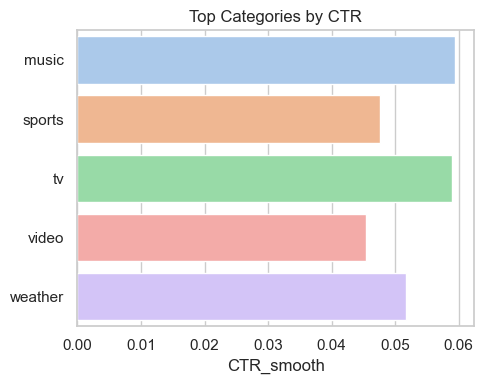

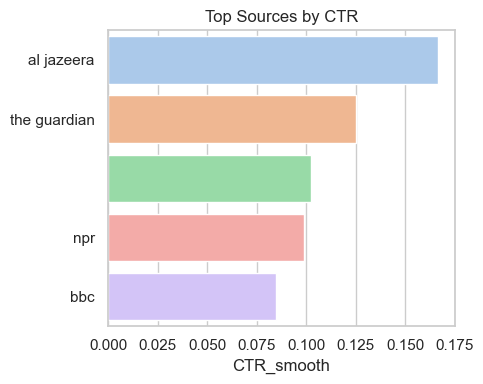

In [152]:
# plot top 5 categories and sources

sns.set(style="whitegrid")
palette = sns.color_palette("pastel", 5)
top_cat = user_train_clean["ctr_category"].nlargest(5, "ctr_smooth").copy()
if top_cat["category_merged"].dtype.name == "category":
    top_cat["category_merged"] = top_cat["category_merged"].cat.remove_unused_categories()
top_source = user_train_clean["ctr_source"].nlargest(5, "ctr_smooth").copy()
if top_source["source_key"].dtype.name == "category":
    top_source["source_key"] = top_source["source_key"].cat.remove_unused_categories()

plt.figure(figsize=(5,4))
sns.barplot(data=top_cat,y="category_merged",x="ctr_smooth",hue="category_merged",palette=palette)
plt.title("Top Categories by CTR")
plt.xlabel("CTR_smooth")
plt.ylabel("")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
sns.barplot(data=top_source,y="source_key",x="ctr_smooth",hue="source_key",palette=palette)
plt.title("Top Sources by CTR")
plt.xlabel("CTR_smooth")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [84]:
train_users = set(user_train_clean["pairs"]["user_id"])
val_users = set(user_test_clean["pairs"]["user_id"])
overlap = train_users.intersection(val_users)
print("Train users:", len(train_users))
print("Val users:", len(val_users))
print("Overlap:", len(overlap))


Train users: 50000
Val users: 50000
Overlap: 5943


Candidate Generation (Recall)

In [85]:
# #articles retrieved for each user

rng = np.random.default_rng(42)

top_popular = 100 # global popularity (for cold start users (no history))
per_cat = 80 # per frequent category
clicked_k = 5 # last k clicks
similar_per_click = 80 # per each of last-k clicks
max_candidates = 400 # total recall size pool cap

user_val_history = user_test_clean["user_history"]


In [86]:
news_train = news_train_clean.copy()
news_val = news_val_clean.copy()

# CONTENT SIMILARITY from TF-IDF feature matrix 
dic_tr = {nid:i for i, nid in enumerate(news_train["news_id"].tolist())}
arr_tr = np.array(news_train["news_id"].tolist())
cat_index_tr = defaultdict(list)
for nid, cat in zip(news_train["news_id"], news_train["category_merged"]):
    cat_index_tr[cat].append(nid)

dic_val = {nid:i for i, nid in enumerate(news_val["news_id"].tolist())}
arr_val = np.array(news_val["news_id"].tolist())
cat_index_val = defaultdict(list)
for nid, cat in zip(news_val["news_id"], news_val["category_merged"]):
    cat_index_val[cat].append(nid)

tfidf = TfidfVectorizer(min_df=3,max_df=0.8,ngram_range=(1,2),strip_accents="unicode",lowercase=True,dtype=np.float32,norm="l2")
X_train = tfidf.fit_transform(news_train["content_plain"])
X_val = tfidf.transform(news_val["content_plain"])
print(X_train.shape, X_val.shape)

# for each last-k clicked articles, get top-N similar articles (news_id)
base = 300  # base size per clicked id

@lru_cache(maxsize=100_000)
def base_sim_train(nid_clicked):
    r = dic_tr.get(nid_clicked, None)
    if r is None: 
        return tuple()
    q = X_train[r]
    sims = (q @ X_val.T).toarray().ravel()
    idx = np.argpartition(-sims, kth=min(base, sims.size-1))[:base]
    idx = idx[np.argsort(-sims[idx])]
    return tuple(arr_val[j] for j in idx)

@lru_cache(maxsize=100_000)
def base_sim_val(nid_clicked):
    r = dic_val.get(nid_clicked, None)
    if r is None: 
        return tuple()
    q = X_val[r]
    sims = (q @ X_val.T).toarray().ravel()
    idx = np.argpartition(-sims, kth=min(base, sims.size-1))[:base]
    idx = idx[np.argsort(-sims[idx])]
    return tuple(arr_val[j] for j in idx)

def content_similarity(nid_clicked, topn=20, exclude_ids=frozenset()):
    out = []
    for nid in base_sim_train(nid_clicked):
        if nid not in exclude_ids:
            out.append(nid)
            if len(out) >= topn: 
                break
    return out

def content_similarity_val(nid_clicked, topn=20, exclude_ids=frozenset()):
    out = []
    for nid in base_sim_val(nid_clicked):
        if nid not in exclude_ids:
            out.append(nid)
            if len(out) >= topn: 
                break
    return out

def approx_max_sim(nids_history, top_k_list_fn, max_take=300):
    score = {}
    for h in nids_history or []:
        cap = top_k_list_fn(h)
        for rank, nid in enumerate(cap[:max_take], start=1):
            s = 1.0 / (rank + 5)
            score[nid] = score.get(nid, 0.0) + s
    return score


(51282, 140562) (42416, 140562)


In [87]:
# POPULAR NEWS prior for each news_id

priors_news = user_train_clean["ctr_news"][["news_id","ctr_smooth"]].rename(columns={"ctr_smooth":"prior_news_ctr"})
priors_cat = user_train_clean["ctr_category"][["category_merged","ctr_smooth"]].rename(columns={"ctr_smooth":"prior_cat_ctr"})
priors_source = user_train_clean["ctr_source"][["source_key","ctr_smooth"]].rename(columns={"ctr_smooth":"prior_source_ctr"})

global_ctr = (user_train_clean["pairs"]["label"].sum() + 1.0) / (len(user_train_clean["pairs"]) + 2.0) # laplace smoothing to avoid 0 prob

news_train = news_train.merge(priors_news, on="news_id", how="left")
news_train["prior_news_ctr"] = news_train["prior_news_ctr"].fillna(global_ctr)

# val news with prior from train (global fallback news -> category -> source -> global)
news_val = news_val.merge(priors_news, on="news_id", how="left")
news_val = news_val.merge(priors_cat, on="category_merged", how="left")
news_val = news_val.merge(priors_source, on="source_key", how="left")
news_val["prior_news_ctr"] = news_val["prior_news_ctr"].fillna(news_val["prior_cat_ctr"]).fillna(news_val["prior_source_ctr"]).fillna(global_ctr)

# sample weights so probability distribution over news_id
pop_weights_tr = news_train["prior_news_ctr"].values
pop_weights_tr = pop_weights_tr / pop_weights_tr.sum()
pop_weights_val = news_val["prior_news_ctr"].values
pop_weights_val = pop_weights_val / pop_weights_val.sum()


In [88]:
# POPULAR CATEGORY and SOURCE prior for each user_id

cat_prior_train = (user_train_clean["ctr_category"].set_index("category_merged")["ctr_smooth"])
cat_prior_train = cat_prior_train / cat_prior_train.sum()
cat_prior_train = cat_prior_train.to_dict()

cat_prior_global = (user_train_clean["ctr_category"].set_index("category_merged")["ctr_smooth"])
cat_prior_global = cat_prior_global / cat_prior_global.sum()
cat_prior_global = cat_prior_global.to_dict()

nid2cat_train = news_train.set_index("news_id")["category_merged"].to_dict()
nid2cat_val = news_val.set_index("news_id")["category_merged"].to_dict()
nid2src_train = news_train.set_index("news_id")["source_key"].to_dict()
nid2src_val = news_val.set_index("news_id")["source_key"].to_dict()
prior_ctr_map = news_val.set_index("news_id")["prior_news_ctr"].to_dict()
is_short_map  = news_val.set_index("news_id")["is_short"].to_dict()

def category_preference(uid, alpha=1.0, tau=0.8):
    clicks_tr  = user_train_clean["user_history"].get(uid, [])
    clicks_val = user_val_history.get(uid, [])
    all_clicks = clicks_tr + clicks_val
    if not all_clicks:
        return {}  # new user
    # category counts
    cat_counts = Counter()
    for nid in all_clicks:
        cat = nid2cat_train.get(nid, nid2cat_val.get(nid))
        if cat:
            cat_counts[cat] += 1
    if not cat_counts:
        return {}
    # laplace smoothing with softmax
    cats   = list(cat_counts.keys())
    counts = np.array([cat_counts[c] for c in cats], dtype=float)
    counts_sm = counts + alpha
    p = counts_sm / counts_sm.sum()
    exps = np.exp(p / tau)
    probs = exps / exps.sum()
    return {c: float(prob) for c, prob in zip(cats, probs)}

def source_for_cat_pref(nid, hist_tr, hist_val):
    src = nid2src_val.get(nid, nid2src_train.get(nid))
    if not src: 
        return 0
    hist_srcs = set(
        [nid2src_train.get(h) for h in (hist_tr or [])] +
        [nid2src_val.get(h) for h in (hist_val or [])]
    )
    return 1 if src in hist_srcs else 0


In [15]:
# NEWS CANDIDATE GENERATION function - Global Top-K

def get_candidates(user_id, history_pair, X_train, dic_tr, X_val, dic_val, arr_val, cat_index_val, news_df_val, pop_weights_val, K_pool):
    hist_tr, hist_val = history_pair
    exclude = set(hist_tr) | set(hist_val)

    # category preference (train + val clicks)
    pref = category_preference(user_id)

    # similarity scores from last-k clicks (train + val)
    lastk_tr  = (hist_tr or [])[-clicked_k:]
    lastk_val = (hist_val or [])[-clicked_k:]
    sim_scores = {} # get similarity scores with click history
    if lastk_tr:
        ss = approx_max_sim(lastk_tr, base_sim_train, max_take=base)
        for k, v in ss.items():
            sim_scores[k] = sim_scores.get(k, 0.0) + v
    if lastk_val:
        ss = approx_max_sim(lastk_val, base_sim_val, max_take=base)
        for k, v in ss.items():
            sim_scores[k] = sim_scores.get(k, 0.0) + v

    # score aLL valid test articles = sim + priors + pref + source familiarity
    scored = []
    for nid, cat in zip(news_df_val["news_id"], news_df_val["category_merged"]):
        # skip already-clicked and too-short articles
        if nid in exclude:
            continue
        if is_short_map.get(nid, False):
            continue
        sim   = float(sim_scores.get(nid, 0.0))
        p_ctr = float(prior_ctr_map.get(nid, 0.0))

        if pref:
            p_cat = float(pref.get(cat, 0.0))
        else:
            p_cat = float(cat_prior_global.get(cat, 0.0))
        src_b = 0.05 * source_for_cat_pref(nid, hist_tr, hist_val)
        score = 0.65 * sim + 0.25 * p_ctr + 0.10 * p_cat + src_b
        scored.append((score, nid))
    # top-K by score
    if not scored:
        return []

    scored.sort(reverse=True)  # desc score
    cand = [nid for (s, nid) in scored[:K_pool]]
    return cand


…processed 2000 imps; running Recall@[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]: 50:0.178, 100:0.252, 150:0.305, 200:0.348, 250:0.394, 300:0.446, 350:0.478, 400:0.496, 450:0.508, 500:0.517, 550:0.520, 600:0.523, 650:0.551, 700:0.556, 750:0.560, 800:0.577
…processed 4000 imps; running Recall@[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]: 50:0.180, 100:0.251, 150:0.308, 200:0.354, 250:0.399, 300:0.452, 350:0.479, 400:0.495, 450:0.507, 500:0.514, 550:0.517, 600:0.518, 650:0.548, 700:0.553, 750:0.560, 800:0.576


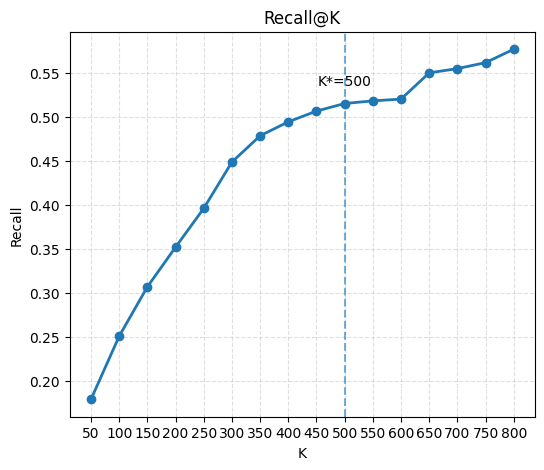

Recall@50: 0.179
Recall@100: 0.251
Recall@150: 0.307
Recall@200: 0.352
Recall@250: 0.396
Recall@300: 0.449
Recall@350: 0.478
Recall@400: 0.494
Recall@450: 0.506
Recall@500: 0.515
Recall@550: 0.518
Recall@600: 0.520
Recall@650: 0.550
Recall@700: 0.555
Recall@750: 0.561
Recall@800: 0.577

Incremental gains:
K 50 to 100: +0.072
K 100 to 150: +0.056
K 150 to 200: +0.045
K 200 to 250: +0.044
K 250 to 300: +0.053
K 300 to 350: +0.030
K 350 to 400: +0.016
K 400 to 450: +0.012
K 450 to 500: +0.009

Best K: 500


In [ ]:
def bestk_recall_curve(test_pairs,get_hist_tr_fn,X_train, dic_tr, X_val, dic_val,arr_val, cat_index_val, news_val, pop_weights_val,K_min=50, K_max=800, step=50,flat_tol=0.01,max_imps=None,progress_every=2000):
    K_list = list(range(K_min, K_max + 1, step))
    K_list = sorted(K_list)
    Kmax = max(K_list)
    df = test_pairs.copy()
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df = df.sort_values(["user_id","time","impression_id"])
    hits = {K:0 for K in K_list}
    total = 0
    seen_imps = 0
    hist_val_so_far = defaultdict(list)
    sample_set = None
    if max_imps:
        sample_set = set(
            df.groupby("impression_id", as_index=False).first().sample(n=min(max_imps, df["impression_id"].nunique()), random_state=42)["impression_id"])
    for uid, grp in df.groupby("user_id", sort=False):
        for imp_id, g in grp.groupby("impression_id", sort=False):
            if sample_set is not None and imp_id not in sample_set:
                continue
            hist_tr  = get_hist_tr_fn(uid)
            hist_val = hist_val_so_far[uid]
            pool_list = get_candidates(uid, (hist_tr, hist_val),X_train, dic_tr, X_val, dic_val,arr_val, cat_index_val, news_val, pop_weights_val, K_pool=Kmax)
            clicked = set(g.loc[g["label"] == 1, "news_id"].tolist())
            if clicked:
                total += 1
                pool_set = set()
                for K in K_list:
                    pool_set.update(pool_list[:K])
                    if clicked & pool_set:
                        hits[K] += 1
                hist_val_so_far[uid].extend(list(clicked))
            seen_imps += 1
            if progress_every and (seen_imps % progress_every == 0):
                print(f"…processed {seen_imps} imps; running Recall@{K_list}: " +
                      ", ".join([f"{K}:{hits[K]/max(total,1):.3f}" for K in K_list]))
    curve = {K: hits[K] / max(total, 1) for K in K_list}
    K_list = sorted(curve.keys())
    vals = [curve[k] for k in K_list]

    # get k where improvement is small (gain < 0.01)
    best_K = K_list[-1]
    improvements = []
    for i in range(1, len(K_list)):
        dR = vals[i] - vals[i-1]
        improvements.append(dR)
        if dR < flat_tol:
            best_K = K_list[i]
            break

    plt.figure(figsize=(6,5))
    plt.plot(K_list, vals, marker='o', linewidth=2)
    plt.xticks(K_list)
    plt.xlabel("K")
    plt.ylabel("Recall")
    plt.title("Recall@K")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.axvline(best_K, linestyle='--', alpha=0.6)
    plt.text(best_K, max(vals)*0.95, f"K*={best_K}", ha='center', va='top')
    plt.show()

    for k in K_list:
        print(f"Recall@{k}: {curve[k]:.3f}")
    print("\nIncremental gains:")
    for i in range(len(improvements)):
        print(f"K {K_list[i]} to {K_list[i+1]}: +{improvements[i]:.3f}")
    print(f"\nBest K: {best_K}")
    return curve, best_K
curve, best_K = bestk_recall_curve(user_test_clean["pairs"],lambda uid: user_train_clean["user_history"].get(uid, []),X_train, dic_tr, X_val, dic_val,arr_val, cat_index_val, news_val, pop_weights_val,K_min=50, K_max=800, step=50,flat_tol=0.01,max_imps=5000)


In [39]:
# get candidate pool on test set with bestK=500

max_candidates = 500

# if user in train set, get history from there
def get_hist(uid, imp_id):
    hist_tr = user_train_clean["user_history"].get(uid, [])
    df = user_test_clean["pairs"]
    imp_time = df.loc[df["impression_id"]==imp_id, "time"].iloc[0]
    hist_val = df[(df["user_id"]==uid) & (df["label"]==1) & (df["time"] < imp_time)]["news_id"].tolist()
    return hist_tr, hist_val

def get_recall(test_pairs, get_hist_tr_fn,X_train, dic_tr, X_val, dic_val,arr_val, cat_index_val, news_val, pop_weights_val, K_pool, max_imps=None, progress_every=5000):
    df = test_pairs.copy()
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df = df.sort_values(["user_id", "time", "impression_id"])

    hist_val_so_far = defaultdict(list)
    hits = total = 0
    seen_imps = set()
    saved_cand = []

    sampled_imps = None
    if max_imps:
        sampled_imps = set(df.groupby("impression_id", as_index=False).first().sample(n=min(max_imps, df["impression_id"].nunique()), random_state=42)["impression_id"])

    for uid, grp in df.groupby("user_id", sort=False):
        for imp_id, g in grp.groupby("impression_id", sort=False):
            if sampled_imps is not None and imp_id not in sampled_imps:
                continue
            if imp_id in seen_imps:
                continue
            seen_imps.add(imp_id)

            hist_tr  = get_hist_tr_fn(uid)
            hist_val = hist_val_so_far[uid]

            pool = get_candidates(uid, (hist_tr, hist_val), X_train, dic_tr, X_val, dic_val, arr_val, cat_index_val, news_val, pop_weights_val, K_pool)
            pool_set = set(pool)

            # save pool for ranking models
            clicked_list = g.loc[g["label"] == 1, "news_id"].tolist()
            clicked_id = clicked_list[0] if clicked_list else None
            saved_cand.append({"impression_id": imp_id,"user_id": uid,"time": g["time"].iloc[0],"pool": pool,"clicked": clicked_id})

            # calculate recall
            clicked = set(clicked_list)
            if clicked:
                total += 1
                hits  += int(bool(clicked & pool_set))
                hist_val_so_far[uid].extend(list(clicked))
            if progress_every and (len(seen_imps) % progress_every == 0):
                print(f"…processed {len(seen_imps)} imps; running Recall@{K_pool}: {hits/max(total,1):.3f}")
    
    cand_df = pd.DataFrame(saved_cand)
    cand_df.to_parquet("val_candidate_pools_k500.parquet", index=False)
    print("cand_df length:", len(cand_df))
    return hits / max(total, 1)

recall = get_recall(user_test_clean["pairs"],lambda uid: user_train_clean["user_history"].get(uid, []),X_train, dic_tr, X_val, dic_val,arr_val, cat_index_val, news_val, pop_weights_val,K_pool=max_candidates, max_imps=10000)
print(f"Recall@{max_candidates}: {recall:.3f}")


…processed 5000 imps; running Recall@500: 0.513
…processed 10000 imps; running Recall@500: 0.516
cand_df length: 10000
Recall@500: 0.516


In [89]:
# dataset for ranking models (with candidate pools)

cand_df = pd.read_parquet("val_candidate_pools_k500.parquet")
for _, row in cand_df.iterrows():
    uid, imp_id, pool, clicked = row["user_id"], row["impression_id"], row["pool"], row["clicked"]
cand_df.head()


,impression_id,user_id,time,pool,clicked
0,71091,U10005,2019-11-15 07:38:13,"[N60637, N50657, N33397, N7889, N62939, N60411...",N36779
1,62816,U10013,2019-11-15 06:42:47,"[N60637, N7119, N64212, N31489, N944, N90, N84...",N5940
2,1871,U10036,2019-11-15 07:55:44,"[N60637, N60411, N56075, N56041, N48100, N4509...",N19990
3,53992,U10041,2019-11-15 15:44:04,"[N23486, N9407, N9335, N59569, N57574, N57437,...",N58748
4,53038,U10061,2019-11-15 12:26:23,"[N60411, N56075, N56041, N48100, N45095, N3649...",N55237


Modeling

In [ ]:
from scipy.sparse import hstack
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sentence_transformers import SentenceTransformer
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import TruncatedSVD


In [90]:
# set training data

train_pairs = user_train_clean["pairs"].copy()

train_pairs["train_idx"] = train_pairs["news_id"].map(dic_tr)
train_pairs = train_pairs[train_pairs["train_idx"].notnull()].copy()
train_pairs["train_idx"] = train_pairs["train_idx"].astype(int)

X_train_pairs = X_train[train_pairs["train_idx"].values]
y_train_pairs = train_pairs["label"].values

print("train_pairs shape:", train_pairs.shape)
print("X_train_pairs shape:", X_train_pairs.shape)


train_pairs shape: (5843444, 8)
X_train_pairs shape: (5843444, 140562)


In [91]:
# get validation ranking table from candidate pools
rows = []
for _, r in cand_df.iterrows():
    user_id = r["user_id"]
    imp_id = r["impression_id"]
    time = r["time"]
    pool = r["pool"]
    clicked = r["clicked"]
    for nid in pool:
        label = 1 if (clicked is not None and nid == clicked) else 0
        rows.append({"impression_id": imp_id,"user_id": user_id,"time": time,"news_id": nid,"label": label,})
val_rank = pd.DataFrame(rows)
print("val_rank shape:", val_rank.shape)
print("unique impressions:", val_rank["impression_id"].nunique())


val_rank shape: (5000000, 5)
unique impressions: 10000


In [92]:
# set validation data

val_rank["val_idx"] = val_rank["news_id"].map(dic_val)
val_rank = val_rank[val_rank["val_idx"].notnull()].copy()
val_rank["val_idx"] = val_rank["val_idx"].astype(int)

X_val_rank = X_val[val_rank["val_idx"].values]
y_val_rank = val_rank["label"].values
print("X_val_rank shape:", X_val_rank.shape)


X_val_rank shape: (5000000, 140562)


In [ ]:
# set validation data for full ranking evaluation

val_pairs2 = user_test_clean["pairs"].copy()
val_pairs2["tfidf_idx"] = val_pairs2["news_id"].map(dic_val)
val_pairs2 = val_pairs2[val_pairs2["tfidf_idx"].notnull()].copy()
val_pairs2["tfidf_idx"] = val_pairs2["tfidf_idx"].astype(int)


In [94]:
# define evaluation metrics function for 2-stage ranking

def get_metrics(df, score_col, name, K_list=(5,)):
    K_list = sorted(K_list)
    metrics = {f"Hit@{K}": 0.0 for K in K_list}
    metrics.update({f"MRR@{K}": 0.0 for K in K_list})
    metrics.update({f"nDCG@{K}": 0.0 for K in K_list})

    n_groups = 0

    for imp_id, g in df.groupby("impression_id", sort=False):
        labels = g["label"].values.astype(float)
        scores = g[score_col].values
        order = np.argsort(-scores)
        labels = labels[order]
        if labels.sum() == 0:
            continue
        n_groups += 1
        for K in K_list:
            topk = labels[:K]

            # Hit@K
            hit = 1.0 if topk.sum() > 0 else 0.0
            metrics[f"Hit@{K}"] += hit

            # MRR@K
            mrr = 0.0
            for i, y in enumerate(topk):
                if y == 1:
                    mrr = 1.0 / (i + 1)
                    break
            metrics[f"MRR@{K}"] += mrr

            # nDCG@K
            disc = 1.0 / np.log2(np.arange(2, K + 2))
            dcg = (topk * disc).sum()
            ideal = np.sort(labels)[::-1][:K]
            idcg = (ideal * disc).sum()
            ndcg = dcg / idcg if idcg > 0 else 0.0
            metrics[f"nDCG@{K}"] += ndcg

    if n_groups == 0:
        return {k: 0.0 for k in metrics}
    for k in metrics:
        metrics[k] /= n_groups
    print("\n", name)
    for k in sorted(metrics.keys()):
        print(f"{k}: {metrics[k]:.4f}")
    return metrics


In [95]:
# define evaluation metrics function for single-stage ranking

def get_metrics_full(val_pairs, score_col, K=5, skip_no_click=True):
    results = []
    for imp, g in val_pairs.groupby("impression_id"):
        g = g.sort_values(score_col, ascending=False)
        labels = g["label"].to_numpy().astype(float)
        if skip_no_click and labels.sum() == 0:
            continue

        L = min(K, len(labels))
        topk = labels[:L]

        # Hit@K
        hit = 1.0 if topk.sum() > 0 else 0.0

        # MRR@K
        ranks = np.where(topk == 1)[0]
        mrr = 1.0 / (ranks[0] + 1) if len(ranks) > 0 else 0.0

        # nDCG@K
        discounts = 1.0 / np.log2(np.arange(2, L + 2))
        dcg = (topk * discounts).sum()
        ideal = np.sort(labels)[::-1][:L]
        idcg = (ideal * discounts).sum()
        ndcg = dcg / idcg if idcg > 0 else 0.0

        results.append((hit, mrr, ndcg))
    results = np.array(results)
    print(f"Hit@{K}: {results[:, 0].mean():.4f}")
    print(f"MRR@{K}: {results[:, 1].mean():.4f}")
    print(f"nDCG@{K}: {results[:, 2].mean():.4f}")


Logistic Regression + TF-IDF

In [96]:
# 2-stage ranking model
lr = LogisticRegression(penalty="l2",C=1.0,max_iter=1000,n_jobs=-1)
lr.fit(X_train_pairs, y_train_pairs)
val_scores_lr = lr.predict_proba(X_val_rank)[:, 1]
val_rank["score_lr"] = val_scores_lr
metrics_lr = get_metrics(val_rank, "score_lr", name="Logistic Regression", K_list=(5,))



 Logistic Regression
Hit@5: 0.0586
MRR@5: 0.0169
nDCG@5: 0.0268


In [97]:
# single-stage ranking model
scores_full_lr = lr.predict_proba(X_val[val_pairs2["tfidf_idx"]])[:, 1]
val_pairs2["score_lr"] = scores_full_lr
metrics_full_lr = get_metrics_full(val_pairs2, "score_lr", K=5)


Hit@5: 0.4836
MRR@5: 0.2301
nDCG@5: 0.2641


XGBoost + TF-IDF

In [98]:
# 2-stage ranking model
xgb = xgb.XGBClassifier(n_estimators=300,max_depth=6,learning_rate=0.1,subsample=0.8,colsample_bytree=0.8,objective="binary:logistic",tree_method="hist",)
xgb.fit(X_train_pairs, y_train_pairs)
val_scores_xgb = xgb.predict_proba(X_val_rank)[:, 1]
val_rank["score_xgb"] = val_scores_xgb
metrics_xgb = get_metrics(val_rank, "score_xgb", name="XGBoost", K_list=(5,))



 XGBoost
Hit@5: 0.0420
MRR@5: 0.0163
nDCG@5: 0.0227


In [ ]:
# single-stage ranking model
scores_full_xgb = xgb.predict_proba(X_val[val_pairs2["tfidf_idx"]])[:, 1]
val_pairs2["score_xgb"] = scores_full_xgb
metrics_full_xgb = get_metrics_full(val_pairs2, "score_xgb", K=5)


Hit@5: 0.4707
MRR@5: 0.2361
nDCG@5: 0.2642


MLP + DistilBERT Embeddings

In [67]:
# get embeddings for news articles

def get_bert_embeddings(texts, batch_size=32):
    model = SentenceTransformer('distilbert-base-nli-mean-tokens')
    emb = model.encode(texts, batch_size=batch_size, show_progress_bar=True)
    return emb.astype(np.float32)

emb_train = get_bert_embeddings(news_train["content_plain"].tolist())
emb_val = get_bert_embeddings(news_val["content_plain"].tolist())
print("emb_train shape:", emb_train.shape)
print("emb_val shape:", emb_val.shape)

nid2idx_train = {nid: i for i, nid in enumerate(news_train["news_id"])}
nid2idx_val = {nid: i for i, nid in enumerate(news_val["news_id"])}

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\manos\.cache\huggingface\hub\models--sentence-transformers--distilbert-base-nli-mean-tokens. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1603 [00:00<?, ?it/s]

Batches:   0%|          | 0/1326 [00:00<?, ?it/s]

emb_train shape: (51282, 768)
emb_val shape: (42416, 768)


In [ ]:
# save embeddings and mappings
np.save("emb_train.npy", emb_train)
np.save("emb_val.npy", emb_val)
os.makedirs("saved_embeddings", exist_ok=True)
with open("saved_embeddings/nid2idx_train.pkl", "wb") as f:
    pickle.dump(nid2idx_train, f)
with open("saved_embeddings/nid2idx_val.pkl", "wb") as f:
    pickle.dump(nid2idx_val, f)


In [100]:
# load pre-saved embeddings and mappings directly
emb_train = np.load("emb_train.npy")
emb_val   = np.load("emb_val.npy")
with open("saved_embeddings/nid2idx_train.pkl", "rb") as f:
    nid2idx_train = pickle.load(f)
with open("saved_embeddings/nid2idx_val.pkl", "rb") as f:
    nid2idx_val = pickle.load(f)


In [101]:
# sample train data to include all positives + sampled negatives
df = train_pairs.copy()
pos = df[df["label"] == 1]
neg = df[df["label"] == 0]
max_train = 300_000
if len(pos) > max_train // 2:
    pos = pos.sample(n=max_train // 2, random_state=42)
neg_n = max_train - len(pos)
neg = neg.sample(n=min(len(neg), neg_n), random_state=42)
mlp_train_df = pd.concat([pos, neg]).sample(frac=1.0, random_state=42).reset_index(drop=True)


In [102]:
# get BERT feature matrix for subset
train_bert_rows = [nid2idx_train[nid] for nid in mlp_train_df["news_id"]]
X_train_bert = emb_train[train_bert_rows].astype("float32")   # (N_train, 768)
y_train_bert = mlp_train_df["label"].values.astype("float32")
print(X_train_bert.shape, y_train_bert.shape)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bert).astype("float32")


(300000, 768) (300000,)


In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BertTrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
train_ds = BertTrainDataset(X_train_scaled, y_train_bert)
train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True, num_workers=0)

class BertMLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_dim, 256),nn.ReLU(),nn.Linear(256, 64),nn.ReLU(),nn.Linear(64, 1))
    def forward(self, x):
        return self.net(x).squeeze(-1)

model = BertMLP(X_train_scaled.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# train in batches
epochs = 5
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_ds)
    print(f"Epoch {epoch}/{epochs} - loss: {avg_loss:.4f}")

Epoch 1/5 - loss: 0.6347
Epoch 2/5 - loss: 0.6237
Epoch 3/5 - loss: 0.6207
Epoch 4/5 - loss: 0.6187
Epoch 5/5 - loss: 0.6175


In [104]:
# batch scoring function

def batch_scoring(model, scaler, df, nid2idx_val, emb_val, batch_size=20_000):
    model.eval()
    n = len(df)
    scores = np.empty(n, dtype="float32")
    with torch.no_grad():
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)

            batch_nids = df["news_id"].iloc[start:end].map(nid2idx_val).values
            Xb = emb_val[batch_nids].astype("float32")
            Xb = scaler.transform(Xb).astype("float32")

            xb_t = torch.from_numpy(Xb).to(device)
            logits = model(xb_t)
            probs = torch.sigmoid(logits).cpu().numpy()
            scores[start:end] = probs
    return scores


In [ ]:
# 2-stage ranking model
val_scores_mlp1 = batch_scoring(model,scaler,val_rank,nid2idx_val,emb_val,batch_size=20_000,)
val_rank["score_mlp1"] = val_scores_mlp1
metrics_mlp1 = get_metrics(val_rank, "score_mlp1", name="MLP (BERT)", K_list=(5,))
print(metrics_mlp1)



 MLP (BERT)
Hit@5: 0.0385
MRR@5: 0.0177
nDCG@5: 0.0230
{'Hit@5': 0.03850587964030436, 'MRR@5': 0.017746522173545463, 'nDCG@5': np.float64(0.023035801352122943)}


In [109]:
# single-stage ranking model
val_scores_full_mlp1 = batch_scoring(model,scaler,val_pairs2,nid2idx_val,emb_val,batch_size=20_000,)
val_pairs2["score_mlp1"] = val_scores_full_mlp1
metrics_full_mlp1 = get_metrics_full(val_pairs2, "score_mlp1", K=5)


Hit@5: 0.4558
MRR@5: 0.2363
nDCG@5: 0.2598


MLP + DistilBERT Embeddings + TF-IDF

In [ ]:
# SVD dimensionality reduction on TF-IDF features

n_components = 64
svd = TruncatedSVD(n_components=n_components,n_iter=10,random_state=42)
svd.fit(X_train)
tfidf_svd_train_news = svd.transform(X_train).astype("float32")
tfidf_svd_val_news = svd.transform(X_val).astype("float32")
svd_train = tfidf_svd_train_news.astype("float32")
svd_val = tfidf_svd_val_news.astype("float32")
print(emb_train.shape, svd_train.shape)


(51282, 768) (51282, 64)


In [116]:
# keep all positives
#rerank_df = val_rank.copy()
pos = val_rank[val_rank["label"] == 1]
# sample negatives to match or slightly exceed positives
neg = val_rank[val_rank["label"] == 0].sample(n=min(4 * len(pos), 400_000),random_state=42)
train_df = pd.concat([pos, neg]).sample(frac=1, random_state=42).reset_index(drop=True)

# get combined train features
train_nids = train_df["news_id"].values
train_svd = svd_val[[nid2idx_val[nid] for nid in train_nids]]
train_bert= emb_val[[nid2idx_val[nid] for nid in train_nids]]

X_train = np.hstack([train_svd, train_bert]).astype("float32")
y_train = train_df["label"].values.astype("float32")
X_train.shape, y_train.shape

((21685, 832), (21685,))

In [117]:
# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype("float32")


In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RankDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(RankDataset(X_train_scaled, y_train),batch_size=1024,shuffle=True,num_workers=0)

class DeepReranker(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_dim, 256),nn.ReLU(),nn.Dropout(0.2),nn.Linear(256, 128),nn.ReLU(),nn.Dropout(0.2),nn.Linear(128, 1))
    def forward(self, x):
        return self.net(x).squeeze(-1)

model = DeepReranker(832).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# train in batches
epochs = 5
for ep in range(1, epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    print(f"Epoch {ep} - Loss: {total_loss/len(train_loader.dataset):.4f}")


Epoch 1 - Loss: 0.3768
Epoch 2 - Loss: 0.2096
Epoch 3 - Loss: 0.1684
Epoch 4 - Loss: 0.1487
Epoch 5 - Loss: 0.1433


In [ ]:
# batch scoring function

def batch_scoring_updated(df, svd_mat, bert_mat, model, scaler, batch_size=20000):
    model.eval()
    scores = np.empty(len(df), dtype="float32")
    with torch.no_grad():
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_nids = df["news_id"].iloc[start:end].map(nid2idx_val).values
            
            Xs = svd_mat[batch_nids]
            Xb = bert_mat[batch_nids]
            X = np.hstack([Xs, Xb]).astype("float32")
            X = scaler.transform(X).astype("float32")
            
            xb_t = torch.from_numpy(X).to(device)
            probs = torch.sigmoid(model(xb_t)).cpu().numpy()
            scores[start:end] = probs
    return scores


In [121]:
# 2-stage ranking model
val_rank["score_mlp2"] = batch_scoring_updated(val_rank, svd_val, emb_val, model, scaler,batch_size=20000)
metrics_mlp2 = get_metrics(val_rank, "score_mlp2", name="MLP (SVD+BERT)", K_list=(5,))
print(metrics_mlp2)



 MLP (SVD+BERT)
Hit@5: 0.6800
MRR@5: 0.3993
nDCG@5: 0.4701
{'Hit@5': 0.6799631081392667, 'MRR@5': 0.3992775343939733, 'nDCG@5': np.float64(0.4701374556646784)}


In [ ]:
# single-stage ranking model
val_pairs2["score_mlp2"] = batch_scoring_updated(val_pairs2,svd_val,emb_val,model,scaler,batch_size=20000)
metrics_full_mlp2 = get_metrics_full(val_pairs2, "score_mlp2", K=5)
print(metrics_full_mlp2)


Hit@5: 0.4864
MRR@5: 0.2347
nDCG@5: 0.2662
None


Results and Evaluation

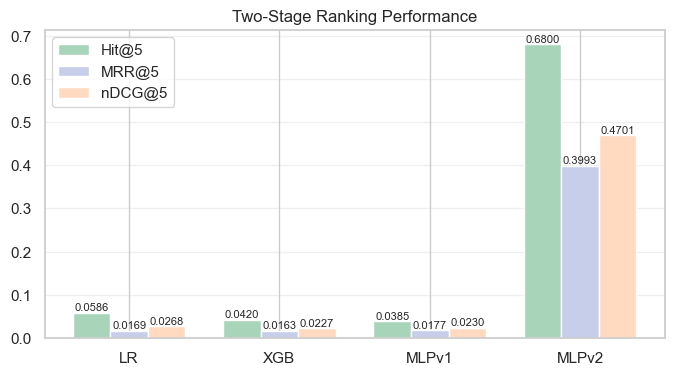

In [153]:
# 2-stage ranking results

models = ["LR", "XGB", "MLPv1", "MLPv2"]
hit5_2stage = [0.0586, 0.0420, 0.0385, 0.6800]
mrr5_2stage = [0.0169, 0.0163, 0.0177, 0.3993]
ndcg5_2stage = [0.0268, 0.0227, 0.0230, 0.4701]
x = np.arange(len(models))

pastel_green ="#A8D5BA"
pastel_lavender = "#C7CEEA"
pastel_peach = "#FFDAC1"
plt.figure(figsize=(8,4))
bar1 = plt.bar(x - 0.25, hit5_2stage, width=0.25, label="Hit@5", color=pastel_green)
bar2 = plt.bar(x, mrr5_2stage, width=0.25, label="MRR@5", color=pastel_lavender)
bar3 = plt.bar(x + 0.25, ndcg5_2stage, width=0.25, label="nDCG@5", color=pastel_peach)
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2,height,f"{height:.4f}",ha='center', va='bottom', fontsize=8)
add_labels(bar1)
add_labels(bar2)
add_labels(bar3)
plt.xticks(x, models)
plt.title("Two-Stage Ranking Performance")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


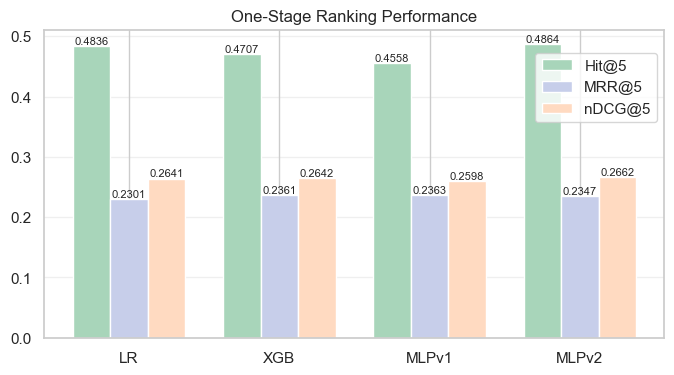

In [161]:
# single-stage ranking results

models = ["LR", "XGB", "MLPv1", "MLPv2"]
hit5_1stage = [0.4836, 0.4707, 0.4558, 0.4864]
mrr5_1stage = [0.2301, 0.2361, 0.2363, 0.2347]
ndcg5_1stage = [0.2641, 0.2642, 0.2598, 0.2662]
x = np.arange(len(models))

plt.figure(figsize=(8,4))
bar1 = plt.bar(x - 0.25, hit5_1stage, width=0.25, label="Hit@5", color=pastel_green)
bar2 = plt.bar(x, mrr5_1stage, width=0.25, label="MRR@5", color=pastel_lavender)
bar3 = plt.bar(x + 0.25, ndcg5_1stage, width=0.25, label="nDCG@5", color=pastel_peach)
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2,height,f"{height:.4f}",ha='center', va='bottom', fontsize=8)
add_labels(bar1)
add_labels(bar2)
add_labels(bar3)
plt.xticks(x, models)
plt.title("One-Stage Ranking Performance")
plt.legend(loc="upper right", bbox_to_anchor=(1, 0.95))
plt.grid(axis='y', alpha=0.3)
plt.show()
